## TimeSeries Recurrent Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-04-16 00:04:31.925392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-16 00:04:31.925423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# look at the data
import os 
fname = os.path.join('../dataset/jena_climate_2009_2016.csv')  
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]   
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
# convert the dataset to a numpy array
temperature = np.zeros((len(lines),))  
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [5]:
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

Number of training samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std 

print(mean)
print(std)

[ 988.74929466    8.82590329  282.9050718     4.31331863   75.87275476
   13.14569946    9.19414209    3.95148184    5.81050741    9.30208943
 1218.45204015    2.14977462    3.56048029  176.4405232 ]
[ 8.50510865  8.77098361  8.86560463  7.08011256 16.62877917  7.6012955
  4.14689697  4.76961017  2.63277288  4.1996886  42.0392747   1.53358803
  2.32305586 85.85032063]


In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [8]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

2022-04-16 00:04:40.651259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-16 00:04:40.651291: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 00:04:40.651315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux): /proc/driver/nvidia/version does not exist
2022-04-16 00:04:40.651628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 00:04:40.697681: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23545200 exceeds 10% 

In [9]:
for samples, targets in train_dataset:
    print("Sample shape: ",samples.shape)
    print("Target shape: ",targets.shape)
    break

2022-04-16 00:04:41.021935: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23545200 exceeds 10% of free system memory.


Sample shape:  (256, 120, 14)
Target shape:  (256,)


In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("../models/checkpoints/jena_lstm_2.keras",
    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                6016      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/10
819/819 [==============================] - 101s 120ms/step - loss: 24.0424 - mae: 3.4898 - val_loss: 10.4249 - val_mae: 2.5148
Epoch 2/10
819/819 [==============================] - 98s 119ms/step - loss: 9.1270 - mae: 2.3544 - val_loss: 10.1310 - val_mae: 2.4889
Epoch 3/10
819/819 [==============================] - 94s 115ms/step - loss: 8.0107 - mae: 2.2091 - val_loss: 9.8260 - val_mae: 2.4526
Epoch 4/10
819/819 [==============================] - 93s 114ms/step - loss: 7.2277 - mae: 2.0915 - val_loss: 9.9640 - val_mae: 2.4641
Epoch 5/10
819/819 [==============================] - 93s 114ms/step - loss: 6.6513 - mae: 2.0046 - val_loss: 10.0566 - val_mae: 2.4882
Epoch 6/10
819/819 [==============================] - 94s 115ms/step - loss: 6.2180 - mae: 1.9399 - val_loss: 10.5854 - val_mae: 2.5440
Epoch 7/10
819/819 [==============================] - 91s 111ms/step - loss: 5.8540 - mae: 1.8825 - val_loss: 10.5337 - val_mae: 2.5434
Epoch 8/10
819/819 [============================

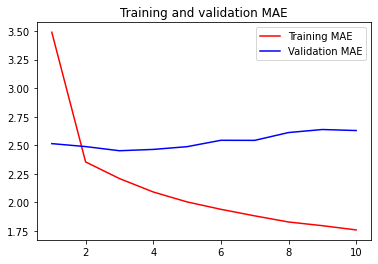

In [20]:
# plotting the performance for the model
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,color="red", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [21]:
model = keras.models.load_model("../models/checkpoints/jena_lstm_2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


405/405 [==============================] - 21s 50ms/step - loss: 10.8028 - mae: 2.5982
Test MAE: 2.60
